In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [2]:
#we make each team start with 2000 ELO
#Ideas to create ELO systems are from: https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
df = pd.read_csv("results.csv")
df.sort_values("date", inplace = True)
df.dropna(inplace = True)
elos = {}
i = 0
for row in df["home_team"]:
    key = df["home_team"][i]
    key2 = df["away_team"][i]
    if (key not in elos):
        elos[key] = 2000
    elif (key2 not in elos):
        elos[key2] = 2000
    i += 1
#1st elo rating works like:
#win = +400 elo
#loss = -400 elo
i=0
for row in df["home_team"]:
    home_score = df["home_score"][i]
    away_score = df["away_score"][i]
    if (home_score > away_score):
        elos[df["home_team"][i]] += 400
        elos[df["away_team"][i]] -= 400
    else:
        elos[df["home_team"][i]] -= 400
        elos[df["away_team"][i]] += 400
    i += 1
values = elos.values()

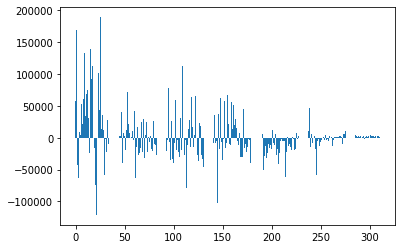

In [3]:
plt.bar(range(len(elos)), values)
plt.show()

In [4]:
#We'll keep the starting elo still at 2000 but we will use different formula for calculating the ELO.
eloWidth = 400
kFactor = 32
for i in elos:
    elos[i] = 2000
def newElo(winnerElo, loserElo, winner, loser):
    expectedWinner = results(winnerElo, loserElo)
    eloChange = kFactor * (1-expectedWinner)
    elos[winner] += eloChange
    elos[loser] -= eloChange
def results(eloA, eloB):
    expected = 1.0/(1+10**((eloB - eloA)/eloWidth))
    return expected
i = 0
for row in df["home_team"]:
    home_score = df["home_score"][i]
    away_score = df["away_score"][i]
    if (home_score > away_score):
       newElo(elos[df["home_team"][i]], elos[df["away_team"][i]], df["home_team"][i], df["away_team"][i])
    else:
       newElo(elos[df["away_team"][i]], elos[df["home_team"][i]], df["away_team"][i], df["home_team"][i])
    i+=1
values = elos.values()

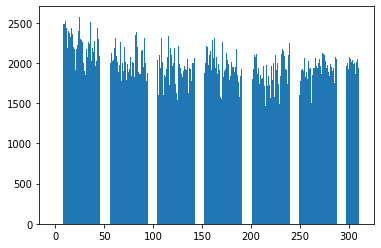

In [5]:
plt.bar(range(len(elos)), values)
plt.show()

In [6]:
#3rd formula is inspired by https://en.wikipedia.org/wiki/World_Football_Elo_Ratings
#Rn = Ro + P where Rn is new rating, Ro is old rating and P is change in points
#P = KG(W-We) K is a factor that changes with the difficulty of the tournament, G is number from goal diff index, W is the result of the match, We is expected winner
for i in elos:
    elos[i] = 2000

K = 25 #Since my data consists mostly friendly(K=20) and random tournaments(K=30) im going to add two K values and divide them by 2.
def goalies(homeScore, awayScore):
    if (np.absolute(homeScore - awayScore) < 2):
        return 1
    elif (np.absolute(homeScore - awayScore) < 3):
        return 3/2
    else:
        return (11+np.absolute(homeScore-awayScore))/8
def eloUpdate(W, G, We, K):
    return K*G*(W-We)
def winPred(elo1, elo2):
    elo1 += 100 #home team gets +100 elo
    dr = np.absolute(elo1-elo2) 
    return 1/(10**(-dr/400)+1)
i = 0
for row in df["home_team"]:
    home_score = df["home_score"][i]
    away_score = df["away_score"][i]
    home_elo = elos[df["home_team"][i]]
    away_elo = elos[df["away_team"][i]]
    G = goalies(home_score, away_score)
    We = winPred(home_elo, away_elo)
    if (home_score > away_score):
        home_elo += eloUpdate(1,G,We,K)
        away_elo += eloUpdate(0,G,1-We,K)
    else:
        home_elo += eloUpdate(0,G,We,K)
        away_elo += eloUpdate(1,G,1-We,K)
    elos[df["home_team"][i]] = home_elo
    elos[df["away_team"][i]] = away_elo
    i+=1
values = elos.values()

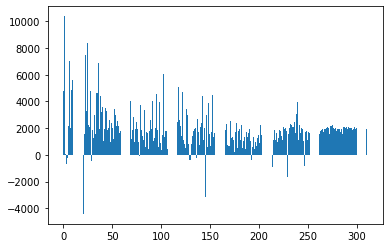

In [7]:
plt.bar(range(len(elos)), values)
plt.show()

In [10]:
#Now I have created 3 different ELO systems and I am going to test which one gives the best predictions for every England game.
i = 0
df["Result"] = 0
for row in df["home_team"]:
    if (df["home_team"][i] == "England" and df["home_score"][i] > df["away_score"][i]):
        df["Result"][i] = 1
    elif (df["away_team"][i] == "England" and df["away_score"][i] > df["home_score"][i]):
        df["Result"][i] = 1
    else:
        df["Result"][i] = 0
    i+=1

c:\users\brandonr\appdata\local\programs\thonny\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\brandonr\appdata\local\programs\thonny\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\brandonr\appdata\local\programs\thonny\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
dfCopy = df[["Result","away_score","home_score"]]
X_train, X_test, y_train, y_test = train_test_split(dfCopy[['Result']], dfCopy[['home_score']], test_size=.2)
model = LinearRegression()
model.fit(X,y)

ValueError: could not convert string to float: 'Scotland'